## Librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import re
import spacy
from tqdm import tqdm
nlp = spacy.load('es_core_news_sm')
import emoji

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
#import seaborn as sns
import itertools

# Preprocesado y modelado
# ==============================================================================
#from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Benchmark
# ==============================================================================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Exportación e importación 
# ==============================================================================
import pickle

## Carga de Datos

In [2]:
# Leemos el fichero y lo pasamos a un DataFrame
tweets_train = pd.read_csv('./data/emoevales_train.tsv', sep='\t+')
tweets_dev = pd.read_csv('./data/emoevales_dev.tsv', sep='\t+')
tweets_test = pd.read_csv('./data/emoevales_test.tsv', sep='\t+')
test_gold = pd.read_csv('./data/emoevales_test_gold.tsv', sep='\t+')

# Eliminamos los tweets que tengan algún valor nulo
tweets_train = tweets_train.dropna()
#print('Número de Tweets_train Cargados: {num}'.format(num=tweets_train.shape[0]))
tweets_dev = tweets_dev.dropna()
#print('Número de Tweets_dev Cargados: {num}'.format(num=tweets_dev.shape[0]))
tweets_test = tweets_test.dropna()
#print('Número de Tweets_test Cargados: {num}'.format(num=tweets_test.shape[0]))

# Mostramos un sample y el número de tweets a procesar
print('Número de Tweets_train a procesar: {num}'.format(num=tweets_train.shape[0]))
print('Número de Tweets_dev a procesar: {num}'.format(num=tweets_dev.shape[0]))
print('Número de Tweets_test a procesar: {num}'.format(num=tweets_test.shape[0]))
print('Número de datos en test_gold: {num}'.format(num=test_gold.shape[0]))

Número de Tweets_train a procesar: 5723
Número de Tweets_dev a procesar: 844
Número de Tweets_test a procesar: 1656
Número de datos en test_gold: 1656


## Limpieza y normalización de el dataset

In [3]:
def limpiar(texto): 
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Cambiar emojis por su significado textual 
    nuevo_texto = emoji.demojize(nuevo_texto, language='es')
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de usuarios
    nuevo_texto = re.sub('user', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\¡\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\¿\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    return nuevo_texto

In [4]:
# Se aplica la función de limpieza a cada tweet
# ==============================================================================
tweets_train['tweet_n'] = tweets_train['tweet'].apply(lambda x: limpiar(x))
tweets_dev['tweet_n'] = tweets_dev['tweet'].apply(lambda x: limpiar(x))
tweets_test['tweet_n'] = tweets_test['tweet'].apply(lambda x: limpiar(x))

In [5]:
tweets_train = [list(x) for x in tweets_train[['tweet_n', 'emotion']].values]
tweets_dev = [list(x) for x in tweets_dev[['tweet_n', 'emotion']].values]
tweets_test = [list(x) for x in tweets_test[['tweet_n']].values]
test_gold = test_gold.values.tolist()

In [6]:
def normalizar(tweets, min_words=2):
    """
    Función que dada una lista de tweets ([tweet, clase]), normaliza los tweets y devuelve una lista
    con los tweets normalizados, descartando aquellos tweets que tras la normalización tengan menos de
    "min_words" palabras en el tweet.
    """

    tweets_list = []
    for tweet in tqdm(tweets):
        # Tokenizamos el tweet realizando los puntos 1,2 y 3.
        tw = nlp(tweet[0].lower().replace('.', ' ').replace('#', ' ').strip())
        
        # Normalizamos Puntos 4,5,6,7 y 8
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (len(word.text) > 2) and (not word.is_stop)
               #and (not word.text.startswith('@'))
               and (not word.text.startswith('https://'))
               and (not ':' in word.text)])
        
        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            tweets_list.append([" ".join(tw), tweet[1]])
    return tweets_list

def normalizar_test(tweets, emotions, min_words=2):
    """ 
    Función que dada una lista de tweets ([tweet]) y una lista de etiquetas ([clase]), 
    normaliza los tweets y devuelve ambas listas con los tweets normalizados, 
    descartando aquellos tweets (y etiquetas respectivas) que tras la normalización 
    tengan menos de "min_words" palabras en el tweet. 
    """

    tweets_list = []
    emotions_list = []
    for i, tweet in tqdm(enumerate(tweets)):
        # Tokenizamos el tweet realizando los puntos 1,2 y 3.
        tw = nlp(tweet[0].lower().replace('.', ' ').replace('#', ' ').strip())
        
        # Normalizamos Puntos 4,5,6,7 y 8
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (len(word.text) > 2) and (not word.is_stop)
               #and (not word.text.startswith('@'))
               and (not word.text.startswith('https://'))
               and (not ':' in word.text)])
        
        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            tweets_list.append([" ".join(tw)])
            emotions_list.append(emotions[i][1])
    return tweets_list, emotions_list

# Normalizamos las frases
X_norm_train = normalizar(tweets_train)
X_norm_dev = normalizar(tweets_dev)
X_norm_test, y_test_gold = normalizar_test(tweets_test, test_gold)

100%|██████████| 844/844 [00:04<00:00, 209.02it/s]
1656it [00:10, 159.36it/s]


### ...

In [7]:
#Guardado de los tweets normalizados en un fichero binario

filename = './models/normalized_train_tweets_string.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm_train, save_list)
save_list.close()

filename = './models/normalized_dev_tweets_string.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm_dev, save_list)
save_list.close()

filename = './models/normalized_test_tweets_string.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm_test, save_list)
save_list.close()

filename = './models/gold_test_string.pickle'
save_list = open(filename,"wb")
pickle.dump(y_test_gold, save_list)
save_list.close()

In [8]:
#Lectura de los tweets normalizados de un fichero binario

filename = './models/normalized_train_tweets_string.pickle'
X_norm_train = pickle.load(open(filename, 'rb'))

filename = './models/normalized_dev_tweets_string.pickle'
X_norm_dev = pickle.load(open(filename, 'rb'))

filename = './models/normalized_test_tweets_string.pickle'
X_norm_test = pickle.load(open(filename, 'rb'))

#¿Tengo que leer también el archivo gold_test_string si no contiene tweets sino etiquetas?

## Extracción de características (Bolsa de palabras)

In [9]:
#El particionado de datos ya está hecho
#pero hay que crear el diccionario de palabras

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X_train = [doc[0] for doc in X_norm_train]
y_train = np.array([doc[1] for doc in X_norm_train])

X_dev = [doc[0] for doc in X_norm_dev]
y_dev = np.array([doc[1] for doc in X_norm_dev])

# Pasamos los tweets normalizados a Bolsa de palabras
vectorizer = TfidfVectorizer(max_features=1500)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train) 
X_dev = vectorizer.transform(X_dev)

# Creación del modelo

In [10]:
mnb = MultinomialNB()
bnb = BernoulliNB()
svm_lin = SVC(kernel='linear')
svm_poly = SVC(kernel='poly')
svm_rbf = SVC(kernel='rbf')
svm_sig = SVC(kernel='sigmoid')
rf_20 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=20, random_state=0)
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'SVM lineal': svm_lin,
                  'SVM polinomico': svm_poly,
                  'SVM Kernel rbf': svm_rbf,
                  'SVM Kernel Sigmoid': svm_sig,
                  'Random Forest d_20': rf_20,
                  'Random Forest d_50': rf_50}


# Ajustamos los modelos
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    model = {}
    model['name'] = k
    # Entrenamiento
    v.fit(X_train, y_train)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM polinomico
CREANDO MODELO: SVM Kernel rbf
CREANDO MODELO: SVM Kernel Sigmoid
CREANDO MODELO: Random Forest d_20
CREANDO MODELO: Random Forest d_50


# Evaluación del modelo

In [11]:
def evaluation(model, name, X_train, y_train, X_dev, y_dev):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y validación
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_dev: Variables de entrada del conjunto de datos de validación
        y_dev: Variable de salida del conjunto de datos de validación
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_dev = model.predict(X_dev)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_dev'] = accuracy_score(y_true=y_dev, y_pred=y_pred_dev)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_dev'] = precision_score(y_true=y_dev, y_pred=y_pred_dev, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_dev'] = recall_score(y_true=y_dev, y_pred=y_pred_dev, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_dev'] = f1_score(y_true=y_dev, y_pred=y_pred_dev, average='weighted')
    
    return model_dict

# Calculamos las métricas de los modelos por separado
evaluacion = list()
for key, model in clasificadores.items():
    evaluacion.append(evaluation(model=model, name=key, 
                                 X_train=X_train, y_train=y_train,
                                 X_dev=X_dev, y_dev=y_dev
                                 ))

# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df

,accuracy_train,accuracy_dev,precision_train,precision_dev,recall_train,recall_dev,f1_train,f1_dev
name,,,,,,,,
Multinomial NB,0.668007,0.598341,0.687751,0.572453,0.668007,0.598341,0.623474,0.541035
Bernoulli NB,0.660839,0.611374,0.662076,0.591342,0.660839,0.611374,0.651552,0.600853
SVM lineal,0.737413,0.646919,0.764579,0.680056,0.737413,0.646919,0.714087,0.614301
SVM polinomico,0.969755,0.546209,0.970771,0.581763,0.969755,0.546209,0.968954,0.451297
SVM Kernel rbf,0.843182,0.639810,0.867477,0.635863,0.843182,0.639810,0.829672,0.590291
SVM Kernel Sigmoid,0.676224,0.655213,0.699565,0.695011,0.676224,0.655213,0.641591,0.618338
Random Forest d_20,0.638112,0.574645,0.774749,0.527303,0.638112,0.574645,0.566416,0.468850
Random Forest d_50,0.811888,0.623223,0.863848,0.660156,0.811888,0.623223,0.801390,0.560508


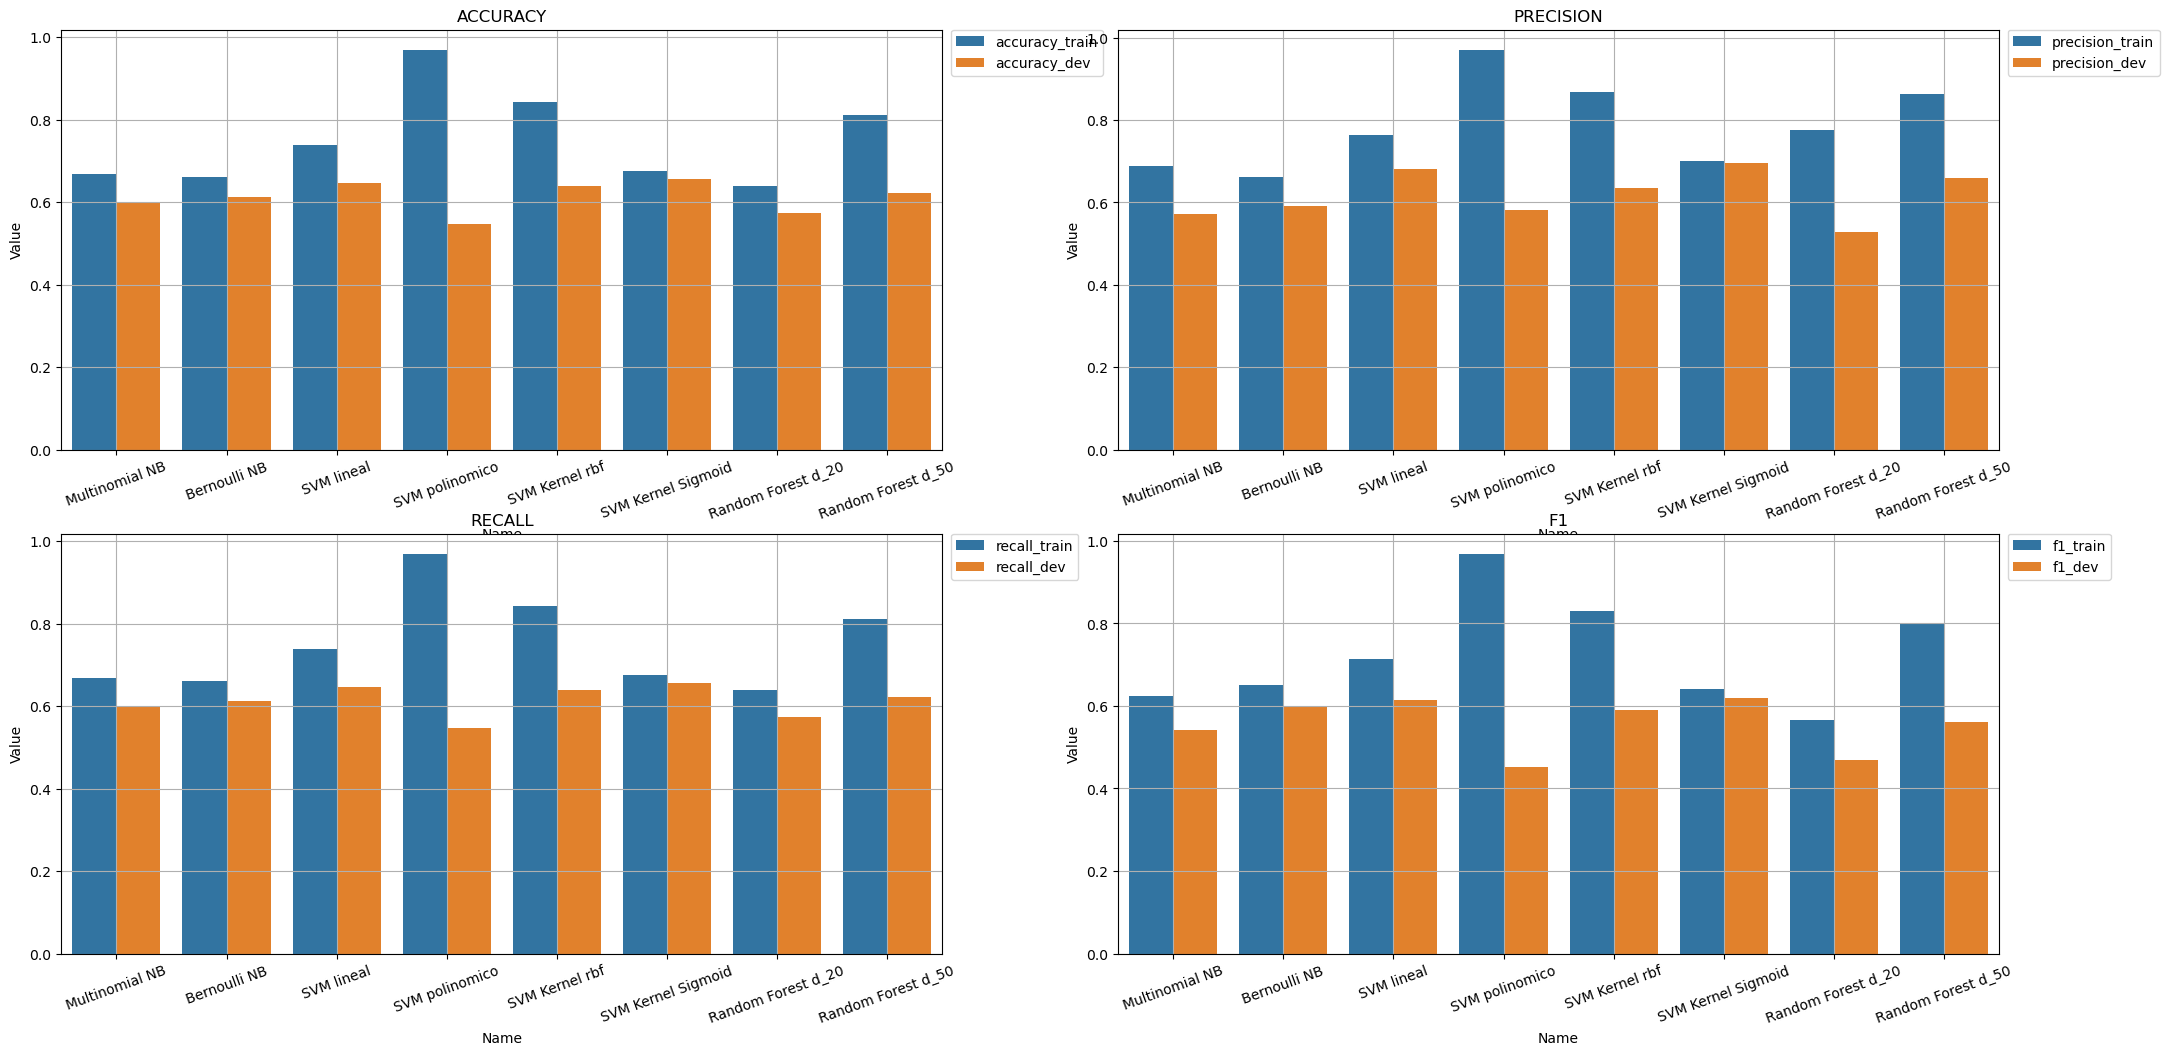

In [12]:
# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = df.reset_index().melt(id_vars='name').rename(columns=str.title)

plt.figure(figsize=(25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x='Name', y='Value', hue='Variable', data=df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=20)
    pos += 1
plt.show()


# Elección de los mejores modelos y exportación en 'Pickle'

In [13]:
# Creación de los modelos con todos los tweets

model_1 = SVC(kernel='sigmoid')
model_1.fit(X_train, y_train)

model_2 = SVC(kernel='linear')
model_2.fit(X_train, y_train)

model_3 = SVC(kernel='rbf')
model_3.fit(X_train, y_train)

model_4 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)
model_4.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=500, random_state=0)

In [14]:
#Obtenemos las métricas de los modelos con los propios datos de validación
labels = ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']

print('Classification report model 1')
print(classification_report(y_true=y_dev, y_pred=model_1.predict(X_dev), labels=labels))
print('Classification report model 2')
print(classification_report(y_true=y_dev, y_pred=model_2.predict(X_dev), labels=labels))
print('Classification report model 3')
print(classification_report(y_true=y_dev, y_pred=model_3.predict(X_dev), labels=labels))
print('Classification report model 4')
print(classification_report(y_true=y_dev, y_pred=model_4.predict(X_dev), labels=labels))

Classification report model 1
              precision    recall  f1-score   support

       anger       0.71      0.38      0.49        85
     disgust       1.00      0.06      0.12        16
        fear       0.75      0.33      0.46         9
         joy       0.63      0.40      0.49       181
      others       0.63      0.92      0.75       414
     sadness       0.93      0.60      0.73       104
    surprise       1.00      0.03      0.06        35

    accuracy                           0.66       844
   macro avg       0.81      0.39      0.44       844
weighted avg       0.70      0.66      0.62       844

Classification report model 2


              precision    recall  f1-score   support

       anger       0.68      0.35      0.47        85
     disgust       1.00      0.06      0.12        16
        fear       0.75      0.33      0.46         9
         joy       0.60      0.41      0.49       181
      others       0.62      0.90      0.74       414
     sadness       0.87      0.60      0.71       104
    surprise       1.00      0.09      0.16        35

    accuracy                           0.65       844
   macro avg       0.79      0.39      0.45       844
weighted avg       0.68      0.65      0.61       844

Classification report model 3
              precision    recall  f1-score   support

       anger       0.77      0.24      0.36        85
     disgust       0.00      0.00      0.00        16
        fear       1.00      0.11      0.20         9
         joy       0.67      0.38      0.48       181
      others       0.60      0.93      0.73       414
     sadness       0.89      0.62      0.73     

## Exportación de los modelos Pickle y la Bolsa de Palabras

In [15]:
#Exportamos los modelos generados por el Algoritmo de Aprendizaje.

filename = './models/model_1_tweets.pickle'
save_model_1 = open(filename,"wb")
pickle.dump(model_1, save_model_1)
save_model_1.close()

filename = './models/model_2_tweets.pickle'
save_model_2 = open(filename,"wb")
pickle.dump(model_2, save_model_2) 
save_model_2.close()

filename = './models/model_3_tweets.pickle'
save_model_3 = open(filename,"wb")
pickle.dump(model_3, save_model_3) 
save_model_3.close()

filename = './models/model_4_tweets.pickle'
save_model_4 = open(filename,"wb")
pickle.dump(model_4, save_model_4)
save_model_4.close()

In [16]:
#Exportar la *Bolsa de Palabras* generada por la clase *TfidfVectorizer*.

filename = './models/vectorizer_bow_tweets.pickle'
save_bow = open(filename,"wb")
pickle.dump(vectorizer, save_bow)
save_bow.close()